# Solving adjoint equations with restarts

Suppose we have a PDE in 'residual form'

$$F(u)=0,\quad u\in V,$$

for some function space $V$.
Given an objective functional $J:V\rightarrow\mathbb R$, the adjoint equation is given by

$$\frac{\partial F}{\partial u}^T\lambda=\frac{\partial J}{\partial u}^T,\quad\lambda\in V.$$

We seek to compute the adjoint solution, $\lambda$.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from firedrake import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import SolveVarFormBlock

In [3]:
def solve_adjoint(*args, tape=None):
    """
    Solver for adjoint problems based on the annotated tape.
    
    There are two options for the first argument:
      1. an annotated assembled objective functional;
      2. the adjoint action of the final time condition for the adjoint problem.
    """
    tape = tape or get_working_tape()
    if isinstance(args[0], AdjFloat):
        J = args[0]
        tape.reset_variables()
        J.adj_value = 1.0  # This value scales J and is propagated through the adjoint solve
    else:
        last_block = tape._blocks[-1]
        if len(last_block._outputs) != 1:
            raise NotImplementedError
        last_block._outputs[0].adj_value = args[0]

    with stop_annotating():
        tape.evaluate_adj(markings=False)

In [4]:
# Define a simple mesh
n = 32
mesh = UnitSquareMesh(n, n)

In [5]:
# Timestepping details
dt = 1.0/n
end_time = 0.5
timesteps_per_export = 4
num_timesteps = int(end_time/dt)
num_exports = num_timesteps//timesteps_per_export

Solve Burgers equation in $\mathbb P2$ space as in the [Firedrake demo](https://firedrakeproject.org/demos/burgers.py.html).

In [6]:
# Define P2 function space and corresponding test function
V = VectorFunctionSpace(mesh, "CG", 2)
v = TestFunction(V)

# Create Functions for the solution and time-lagged solution
u = Function(V, name="Velocity")
u_ = Function(V)

# Assign initial condition
x, y = SpatialCoordinate(mesh)
u_ = interpolate(as_vector([sin(pi*x), 0]), V)
u.assign(u_)

# Set diffusivity constant
nu = Constant(0.0001)

# Define nonlinear form
F = (inner((u - u_)/dt, v) + inner(dot(u, nabla_grad(u)), v) + nu*inner(grad(u), grad(v)))*dx

# Store forward solution at export steps so we can plot again later
forward_solutions = [u.copy(deepcopy=True), ]

# Time integrate
i = 0
t = 0.0
while (t < end_time):
    solve(F == 0, u)
    u_.assign(u)
    t += dt
    i += 1
    if i % timesteps_per_export == 0:
        forward_solutions.append(u.copy(deepcopy=True))

## Objective functional

In order to solve the adjoint equation, we need an objective functional. For this example, consider the following integral over the 'upstream boundary' at the final time $T$:

$$J(u)=\int_{\Gamma_2}u|_{t=T}\cdot u_{t=T}\;\mathrm ds,
\quad\quad\Gamma_2=\{(1,y)\mid y\in(0,1)\}.$$

In [7]:
# First off, extract the final time condition from J
J_form = inner(u, u)*ds(2)

Solve adjoint using a hand-coded final time condition

In [8]:
with stop_annotating():
    J = assemble(J_form)
    dJdu = assemble(derivative(J_form, u))
    solve_adjoint(dJdu)

Plot forward and adjoint solutions

<IPython.core.display.Javascript object>


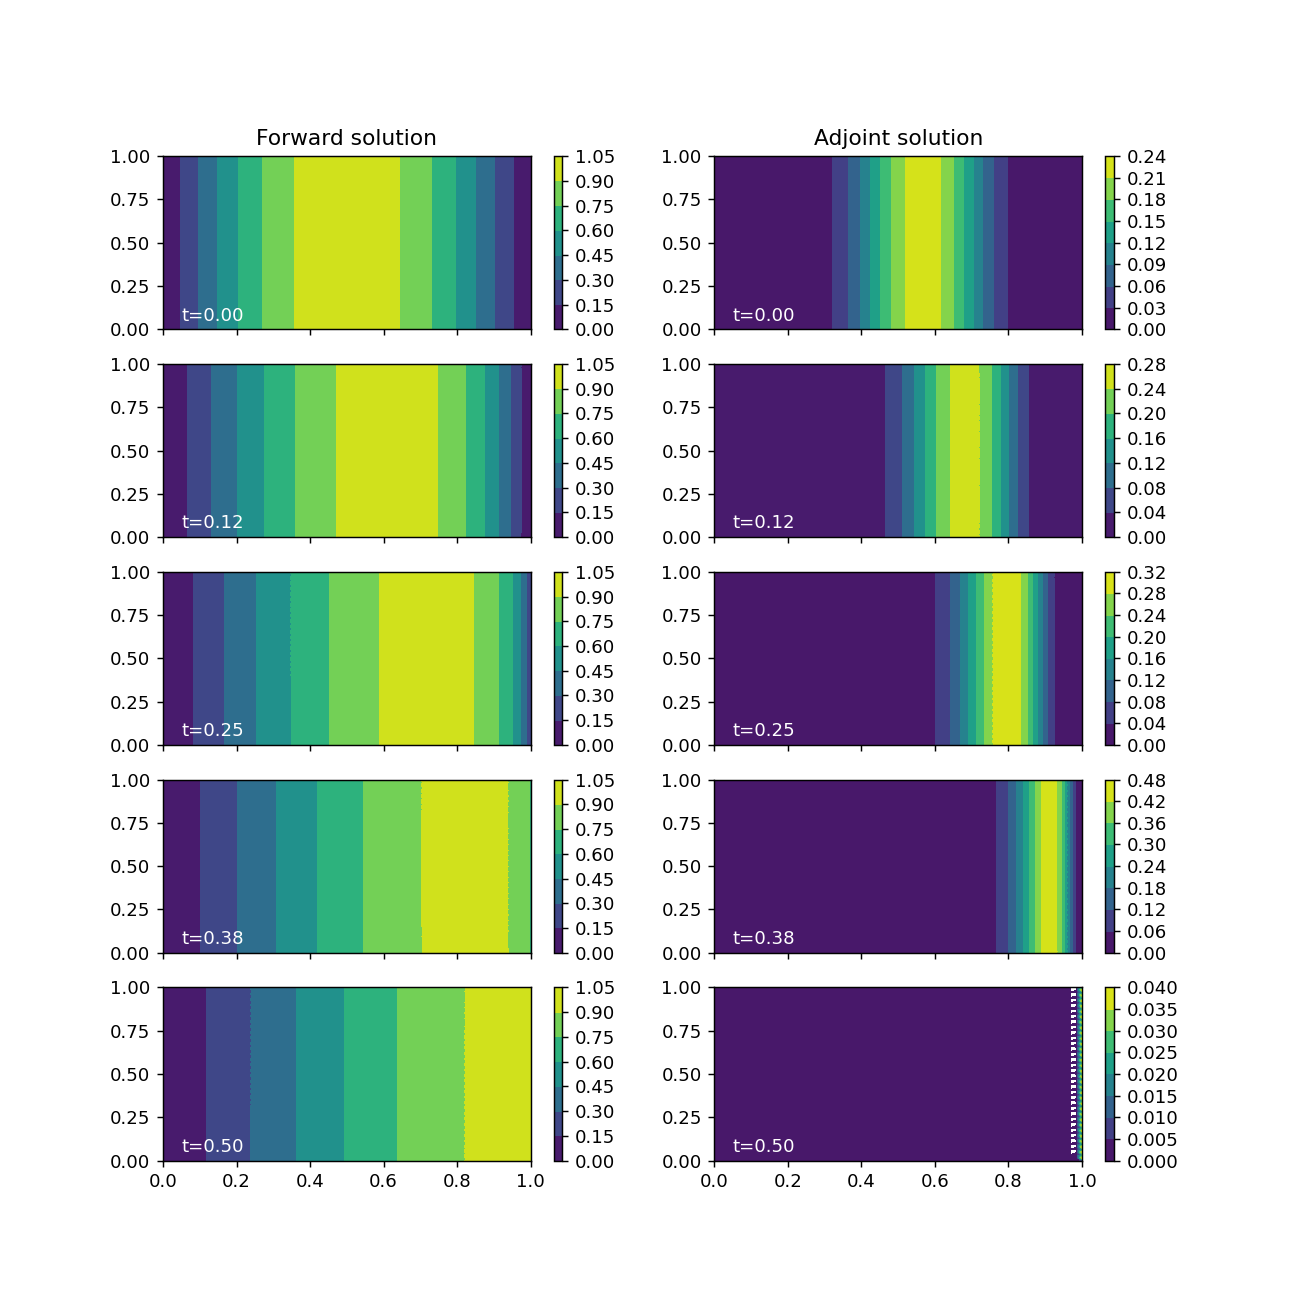

In [9]:
tape = get_working_tape()
solve_blocks = [block for block in tape.get_blocks() if isinstance(block, SolveVarFormBlock)]
assert len(solve_blocks) == num_timesteps
for block in solve_blocks:
    assert block.adj_sol is not None
adjoint_solutions = []

# Plot adjoint solutions at matching timesteps to forward
fig, axs = plt.subplots(num_exports+1, 2, sharex='col', figsize=(10, 10))
for i in range(num_exports+1):
    t = i*timesteps_per_export*dt
    fig.colorbar(tricontourf(forward_solutions[i], axes=axs[i, 0]), ax=axs[i, 0]);
    adjoint_solution = dJdu if i == num_exports else solve_blocks[timesteps_per_export*i].adj_sol
    fig.colorbar(tricontourf(adjoint_solution, axes=axs[i, 1]), ax=axs[i, 1]);
    adjoint_solutions.append(adjoint_solution)
    axs[i, 0].annotate('t={:.2f}'.format(t), (0.05, 0.05), color='white');
    axs[i, 1].annotate('t={:.2f}'.format(t), (0.05, 0.05), color='white');
axs[0, 0].set_title('Forward solution');
axs[0, 1].set_title('Adjoint solution');

In [10]:
tape.clear_tape()

Solve forward again

In [11]:
# Define P2 function space and corresponding test function
V = VectorFunctionSpace(mesh, "CG", 2)
v = TestFunction(V)

# Create Functions for the solution and time-lagged solution
u = Function(V, name="Velocity")
u_ = Function(V)

# Assign initial condition
x, y = SpatialCoordinate(mesh)
u_ = interpolate(as_vector([sin(pi*x), 0]), V)
u.assign(u_)

# Set diffusivity constant
nu = Constant(0.0001)

# Define nonlinear form
F = (inner((u - u_)/dt, v) + inner(dot(u, nabla_grad(u)), v) + nu*inner(grad(u), grad(v)))*dx

# Store forward solution at export steps so we can plot again later
forward_solutions = [u.copy(deepcopy=True), ]

# Time integrate
i = 0
t = 0.0
while (t < end_time):
    solve(F == 0, u)
    u_.assign(u)
    t += dt
    i += 1
    if i % timesteps_per_export == 0:
        forward_solutions.append(u.copy(deepcopy=True))

Solve adjoint in the usual manner

In [12]:
J_form = inner(u, u)*ds(2)
J = assemble(J_form)
solve_adjoint(J)

Plot adjoint solutions computed using both methods

<IPython.core.display.Javascript object>


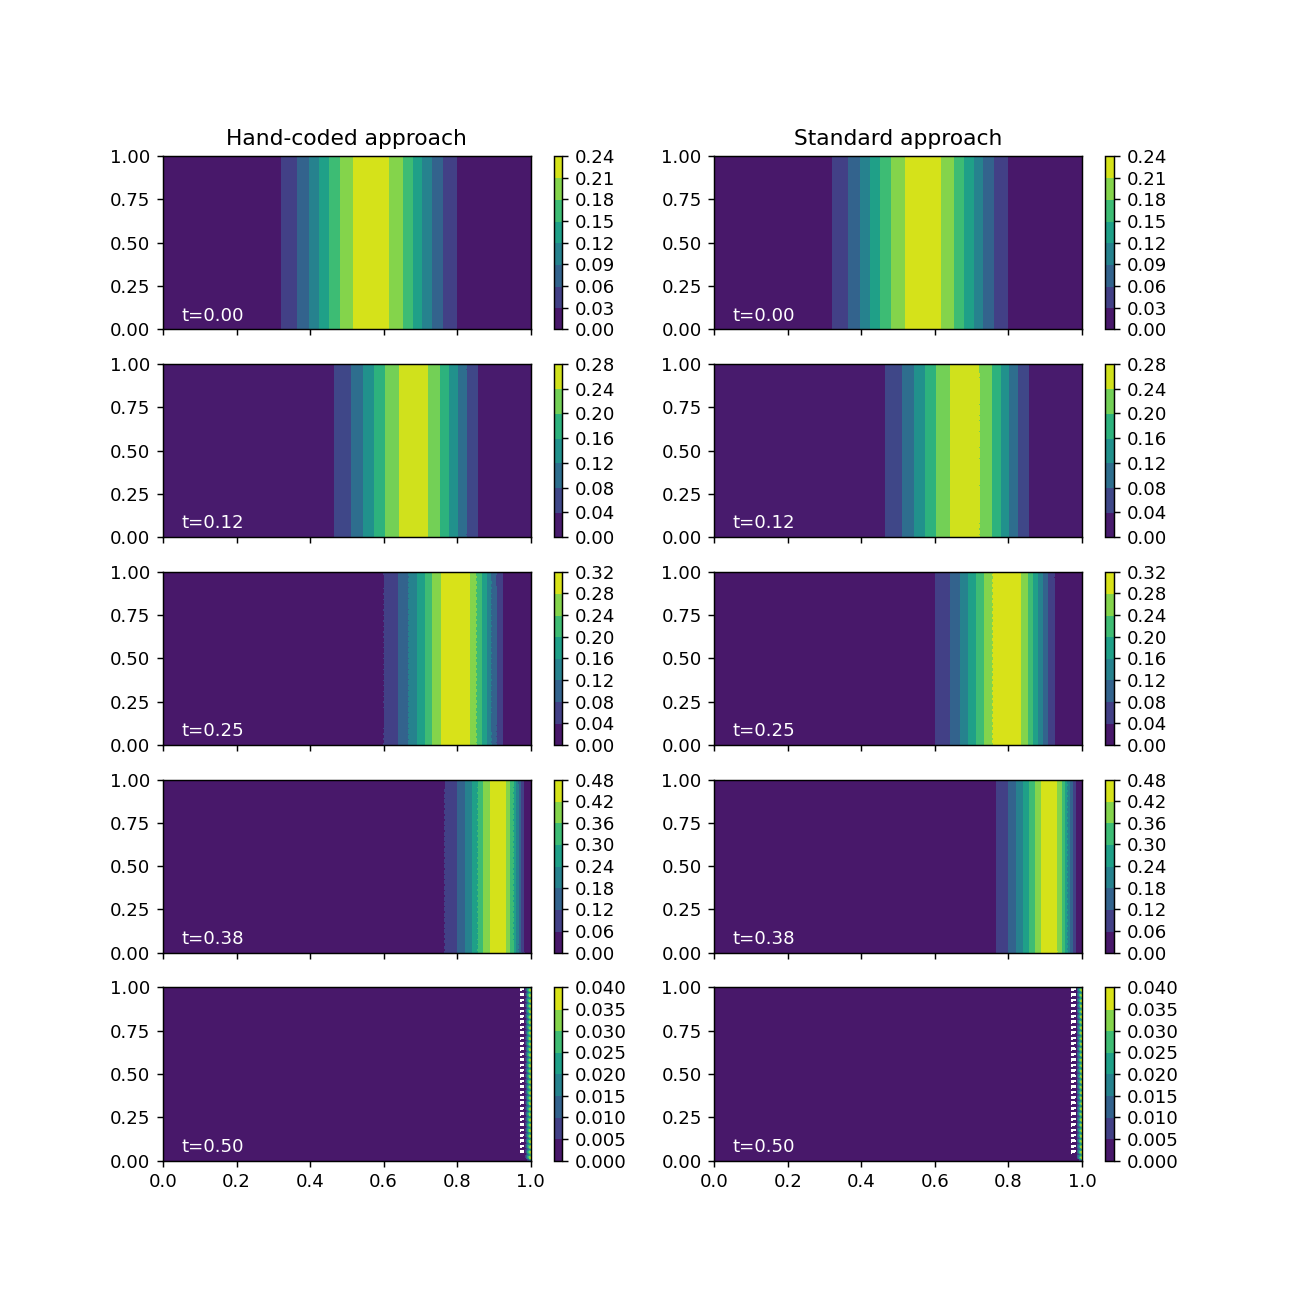

In [13]:
tape = get_working_tape()
solve_blocks = [block for block in tape.get_blocks() if isinstance(block, SolveVarFormBlock)]
assert len(solve_blocks) == num_timesteps
for block in solve_blocks:
    assert block.adj_sol is not None

# Plot adjoint solutions at matching timesteps to forward
fig, axs = plt.subplots(num_exports+1, 2, sharex='col', figsize=(10, 10))
for i in range(num_exports+1):
    t = i*timesteps_per_export*dt
    fig.colorbar(tricontourf(adjoint_solutions[i], axes=axs[i, 0]), ax=axs[i, 0]);
    adjoint_solution = dJdu if i == num_exports else solve_blocks[timesteps_per_export*i].adj_sol
    fig.colorbar(tricontourf(adjoint_solution, axes=axs[i, 1]), ax=axs[i, 1]);
    axs[i, 0].annotate('t={:.2f}'.format(t), (0.05, 0.05), color='white');
    axs[i, 1].annotate('t={:.2f}'.format(t), (0.05, 0.05), color='white');
    assert np.allclose(adjoint_solution.dat.data, adjoint_solutions[i].dat.data)
axs[0, 0].set_title('Hand-coded approach');
axs[0, 1].set_title('Standard approach');